In [ ]:
pip install transformers

In [ ]:
pip install --upgrade transformers


<font color='skyblue' size=6em>#1 LOADING THE PIX2STRUCT MODEL DIRECTLY FROM HUGGING FACE LIBRARY</font>


In [3]:
# Load model directly
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("google/pix2struct-textcaps-base")
model = Pix2StructForConditionalGeneration.from_pretrained("google/pix2struct-textcaps-base")


<font color='skyblue' size=6em>#2 INPUT AND VIEW IMAGE URL OR LOCAL PATH</font>

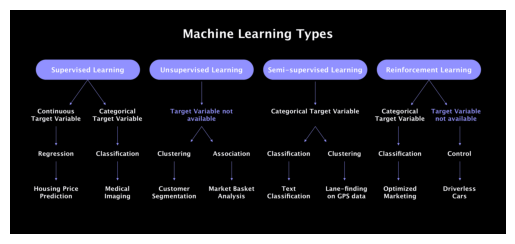

In [6]:
import io
import requests
from PIL import Image
import matplotlib.pyplot as plt

def load_image(source):
    if source.startswith("http"):
        # Load image from URL
        response = requests.get(source, stream=True)
        response.raise_for_status()  # Raise an exception if the request was unsuccessful
        image = Image.open(io.BytesIO(response.content))
    else:
        # Load image from local path
        image = Image.open(source)

    return image

# Provide either an image URL or image path
image_source = "https://cdn-clekk.nitrocdn.com/tkvYXMZryjYrSVhxKeFTeXElceKUYHeV/assets/images/optimized/rev-82dec77/wp-content/uploads/2021/05/machine-learning-types-infographics_1-1536x695.png"  # URL or local file path

image = load_image(image_source)
text = "A picture of"

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [7]:
#loading input to model
inputs = processor(images=image, text=text, return_tensors="pt")

<font color='skyblue' size=6em>#3 INFERENCE/PREDICTION</font>

In [8]:
predictions = model.generate(**inputs)
print(processor.decode(predictions[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


A picture of machine learning types.


<font color='skyblue' size=6em>#4 pix2struct model SIZE</font>

In [9]:
model_size = sum(p.numel() for p in model.parameters()) / (1024 * 1024)  # in MB
print(f"Size of the loaded model: {model_size:.2f} MB")

Size of the loaded model: 269.21 MB


<font color='skyblue' size=6em>#5 INFERENCE TIME of pix2struct</font>

In [10]:
import time
start_time = time.time()
predictions = model.generate(**inputs)
end_time = time.time()

inference_time = end_time - start_time
print("Inference Time:", inference_time, "seconds")

Inference Time: 20.105969667434692 seconds


In [ ]:
pip install onnx

In [ ]:
pip install optimum[exporters]

In [ ]:
pip install onnxruntime

In [14]:
#checking attributes in configuration
from optimum.exporters.onnx.model_configs import Pix2StructOnnxConfig

print(dir(Pix2StructOnnxConfig))

['ATOL_FOR_VALIDATION', 'DEFAULT_ONNX_OPSET', 'DUMMY_INPUT_GENERATOR_CLASSES', 'DUMMY_PKV_GENERATOR_CLASS', 'MIN_TORCH_VERSION', 'MIN_TRANSFORMERS_VERSION', 'NORMALIZED_CONFIG_CLASS', 'PAD_ATTENTION_MASK_TO_PAST', 'PATCHING_SPECS', 'USE_PAST_IN_INPUTS', 'USE_PRESENT_IN_OUTPUTS', '_TASK_TO_COMMON_OUTPUTS', '__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_create_dummy_input_generator_classes', 'add_past_key_values', 'fix_dynamic_axes', 'flatten_output_collection_property', 'flatten_past_key_values', 'generate_dummy_inputs', 'generate_dummy_inputs_for_validation', 'inputs', 'is_torch_support_available', 'is_transformers_support_av

In [15]:
from transformers.models import pix2struct
from optimum.exporters.tasks import TasksManager
#list of tasks pix2struct can perform
pix2struct_tasks = list(TasksManager.get_supported_tasks_for_model_type("pix2struct", "onnx").keys())
print(pix2struct_tasks)

['image-to-text', 'image-to-text-with-past', 'visual-question-answering', 'visual-question-answering-with-past']


<font color='skyblue' size=6em>#6 CONVERSION TO ONNX FORMAT</font>

In [18]:
from optimum.exporters.onnx import main_export
from transformers import AutoConfig

model_id = "google/pix2struct-textcaps-base"
config = AutoConfig.from_pretrained(model_id)

main_export(
    model_id,
    output="/content/pix2struct_onnx",
    no_post_process=True,
    model_kwargs={"output_attentions": True},
)

Framework not specified. Using pt to export to ONNX.
Automatic task detection to image-to-text-with-past.
Using framework PyTorch: 2.0.1+cu118


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Using framework PyTorch: 2.0.1+cu118


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Using framework PyTorch: 2.0.1+cu118
Asked a sequence length of 16, but a sequence length of 1 will be used with use_past == True for `decoder_input_ids`.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Validating ONNX model /content/pix2struct_onnx/encoder_model.onnx...
	-[✓] ONNX model output names match reference model (last_hidden_state)
	- Validating ONNX Model output "last_hidden_state":
		-[✓] (2, 16, 768) matches (2, 16, 768)
		-[x] values not close enough, max diff: 5.46872615814209e-05 (atol: 1e-05)
Validating ONNX model /content/pix2struct_onnx/decoder_model.onnx...
	-[✓] ONNX model output names match reference model (present.6.decoder.value, logits, present.1.decoder.key, present.1.decoder.value, present.2.decoder.value, present.4.encoder.value, present.4.encoder.key, present.2.encoder.value, present.9.encoder.value, present.10.decoder.key, present.7.encoder.value, present.11.encoder.value, present.4.decoder.key, present.11.encoder.key, present.10.decoder.value, present.5.encoder.value, present.8.encoder.value, present.3.encoder.value, present.10.encoder.key, present.7.encoder.key, present.8.encoder.key, present.3.decoder.key, present.6.encoder.value, present.9.encoder.key

<font color='skyblue' size=6em>#7 SIZE OF ONNX MODEL</font>

In [27]:
import onnx
import os

def find_onnx_module_size_mb(onnx_file_path):
  size_bytes = os.path.getsize(onnx_file_path)
  size_mb = size_bytes / 1048576
  return size_mb

def main():
  onnx_file_paths = ["/content/pix2struct_onnx/encoder_model.onnx", "/content/pix2struct_onnx/decoder_model.onnx", "/content/pix2struct_onnx/decoder_with_past_model.onnx"]
  for onnx_file_path in onnx_file_paths:
    size_mb = find_onnx_module_size_mb(onnx_file_path)
    print(f"The size of {onnx_file_path} is {size_mb} MB.")

if __name__ == "__main__":
  main()


The size of /content/pix2struct_onnx/encoder_model.onnx is 350.526385307312 MB.
The size of /content/pix2struct_onnx/decoder_model.onnx is 726.866044998169 MB.
The size of /content/pix2struct_onnx/decoder_with_past_model.onnx is 672.8341856002808 MB.
